# Seeing White<sup>*</sup> on a Map

This notebook demonstrates some of the data wrangling and mapping capabilities
of the `censusdis` package. It does the following:

1. Load metadata on the US Census redistricting data set from 2020
2. Load data on total population and the population of various ractial groups
   for every county in the United States
3. Determine the fraction of the population that is white
4. Plot the results on a map

----

<sup>*</sup>With apologies to the [Seeing White](https://www.sceneonradio.org/seeing-white/) podcast for borrowing the name.

## Basic imports

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.maps as cdm
from censusdis.states import ALL_STATES_AND_DC

## Setup

For more details on what we are setting up here, see the comments 
in this [introductory notebook](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb).


In [3]:
CENSUS_API_KEY = None

In [4]:
YEAR = 2020
DATASET = "dec/pl"
GROUP = "P2"

## Fetch metadata

We will fetch the metadata on what fields are available and then select the ones
that represent the population count of people who identify as white, possibly mixed 
with one or more other races and those who identify as white alone.

In [5]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

df_all_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)

df_all_variables

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,dec/pl,P2,P2_001N,!!Total:,NaN,None
1,2020,dec/pl,P2,P2_002N,!!Total:!!Hispanic or Latino,NaN,None
2,2020,dec/pl,P2,P2_003N,!!Total:!!Not Hispanic or Latino:,NaN,None
3,2020,dec/pl,P2,P2_004N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None
4,2020,dec/pl,P2,P2_005N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None
...,...,...,...,...,...,...,...
68,2020,dec/pl,P2,P2_069N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None
69,2020,dec/pl,P2,P2_070N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None
70,2020,dec/pl,P2,P2_071N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None
71,2020,dec/pl,P2,P2_072N,!!Total:!!Not Hispanic or Latino:!!Population...,NaN,None


In [6]:
df_total_variables = df_all_variables[
    df_all_variables["LABEL"].str.endswith("!!Total:")
]
df_white_alone_variables = df_all_variables[
    df_all_variables["LABEL"].str.endswith("White alone")
]

total_variables = list(df_total_variables["VARIABLE"])
white_alone_variables = list(df_white_alone_variables["VARIABLE"])

## Load data

Now that we know what fields we are interested in we can load data for those fields at the county level for all 50 states and DC. Since we are going to want to plot it, we add `with_geometry=True` so that we get back a `gpd.GeoDataFrame` with the geometry of every county instead of a plain `pd.DataFrame`.

In [7]:
gdf_counties = ced.download(
    DATASET,
    YEAR,
    total_variables + white_alone_variables,
    state=ALL_STATES_AND_DC,
    county="*",
    api_key=CENSUS_API_KEY,
    with_geometry=True,
)

In [8]:
gdf_counties.head()

,STATE,COUNTY,P2_001N,P2_005N,geometry
0,01,001,58805,41582,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,01,003,231767,186495,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,01,005,25223,11086,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,01,007,22293,16442,"POLYGON ((-87.42194 33.00338, -87.33177 33.005..."
4,01,009,59134,49764,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


## Summarize the white population

The next step is to total up the people who identify as white, possibly with other races,
and those who identify as white alone.

In [9]:
gdf_counties["white_alone"] = gdf_counties[white_alone_variables].sum(axis=1)

In [10]:
gdf_counties["pct_white_alone"] = 100.0 * (
    gdf_counties["white_alone"] / gdf_counties[total_variables[0]]
)

In [11]:
gdf_counties[total_variables + ["white_alone", "pct_white_alone"]].head()

,P2_001N,white_alone,pct_white_alone
0,58805,41582,70.711674
1,231767,186495,80.466589
2,25223,11086,43.951949
3,22293,16442,73.754093
4,59134,49764,84.154632


In [12]:
gdf_counties[["pct_white_alone"]].describe()

,pct_white_alone
count,3143.000000
mean,74.150915
std,19.804085
min,1.776396
25%,62.575904
50%,80.725998
75%,90.337848
max,97.404829


## Load state shapefile

When we plot the data on a map, we also want to plot the boundaries of
the states. The API we will use will download the shapefiles from the 
US Census and cache them in a local filesystem.

If you want to browse available files you can look at the US Census 
[cartographic boundary page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html).

The specific zip file the code will download for us is the 2020 500,000:1 scale state
boundary file
[`cb_2020_us_state_500k.zip`](https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip). 

In [13]:
reader = cdm.ShapeReader(year=YEAR)

In [14]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[gdf_state_bounds["STATEFP"].isin(ALL_STATES_AND_DC)]

## Plot on a map

This is a basic plot, that you can style as you wish. Note that we use `cdm.plot_us` and `cdm.plot_us_boundary` because they take care of moving Alaska and Hawaii to a location 
where they are easy to visualize. If we did not do this, they would appear in their actual
geographic locations relatively far from the continental US and the Aleutian islands would 
be split at ±180° longitude. 

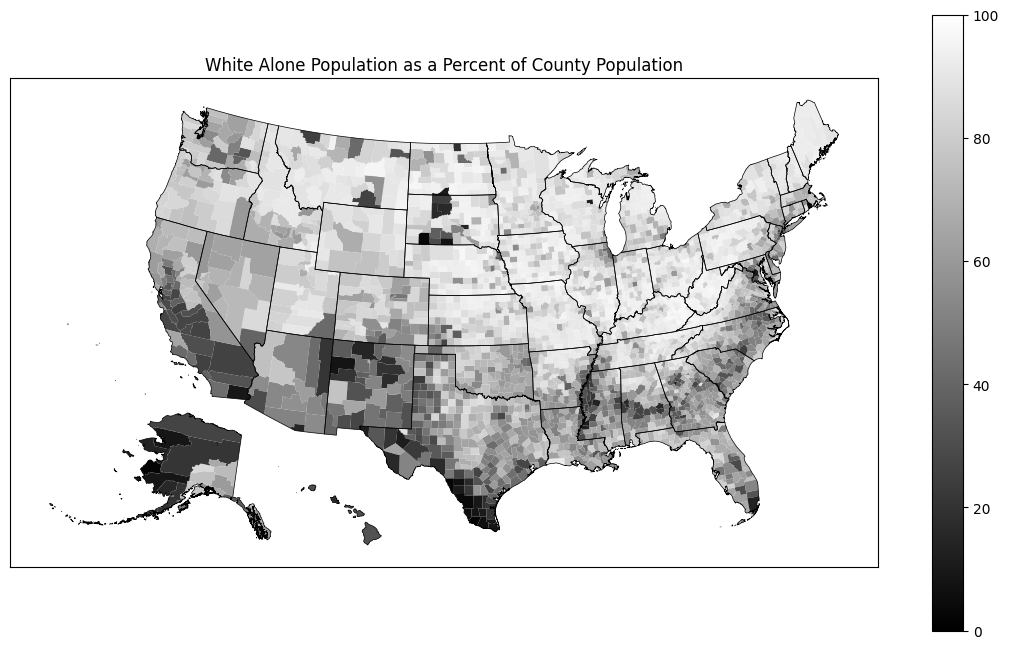

         3897445 function calls (3873517 primitive calls) in 1.978 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.442    0.110    0.442    0.110 {method '_transform' of 'pyproj._transformer._Transformer' objects}
        2    0.208    0.104    0.208    0.104 {pyproj._transformer.from_crs}
        5    0.128    0.026    0.131    0.026 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
     1223    0.080    0.000    0.120    0.000 coords.py:52(xy)
     9275    0.052    0.000    0.068    0.000 cycler.py:364(by_key)
    42221    0.044    0.000    0.146    0.000 decorators.py:62(wrapped)
     4615    0.032    0.000    0.075    0.000 path.py:321(make_compound_path)
     6765    0.027    0.000    0.047    0.000 inspect.py:626(cleandoc)
     2992    0.026    0.000    0.026    0.000 __init__.py:101(check_in_list)
   513868    0.025    0.000    0.025    0.000 {method 'append' of 

In [17]:
%%prun

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 8)

col, name = "pct_white_alone", "White Alone"

ax = cdm.plot_us(
    gdf_counties,
    col,
    cmap="gray",
    legend=True,
    vmin=0.0,
    vmax=100.0,
)

ax = cdm.plot_us_boundary(gdf_state_bounds, edgecolor="black", linewidth=0.5, ax=ax)

ax.set_title(f"{name} Population as a Percent of County Population")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)